In [1]:
import numpy as np
import tofpipe
import matplotlib.pyplot as plt
import time
from scipy.ndimage import gaussian_filter
import queue
from skimage.measure import label

import numpy as np
import ctypes
import abc
from sys import platform
import conn_tcp
import math

conn = conn_tcp.TCPSocket
model = conn(address="192.168.1.13", port=5000, conn_type='zmq')
model.open()

connecting to  192.168.1.13 5000
Client Connected


In [3]:
phase_img_clean, intensity_img_clean, phase_meta_clean, intensity_meta_clean = model.get_image()

In [4]:
phase_img, intensity_img, phase_meta, intensity_meta = model.get_image()

In [5]:
def preprocess_image(image):
    image = np.nan_to_num(image)
    image = np.clip(image, 0, 0.5)
    image = gaussian_filter(image, 1)
    return image

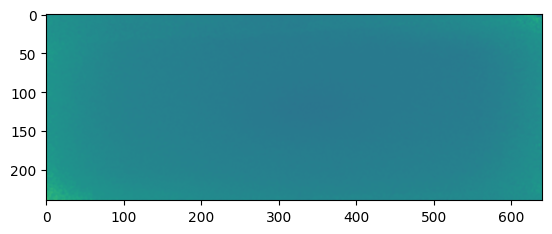

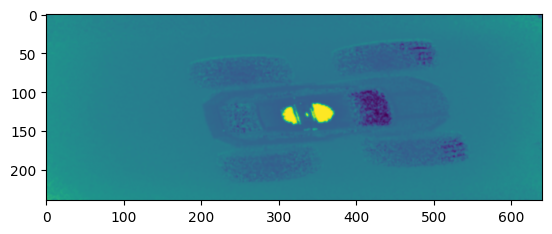

In [6]:
plt.imshow(preprocess_image(phase_img_clean), vmin=0, vmax=0.5)
plt.show()
plt.imshow(preprocess_image(phase_img), vmin=0, vmax=0.5)
plt.show()

In [7]:
# We create an numpy array alpha with the angle the ray from each angle has versus the vertical axis in radians. Out camera looks down, so the exact middle angle has 0.
axis_scales = [.004, .002]
alphas = np.zeros_like(phase_img_clean)
for i in range(alphas.shape[0]):
    for j in range(alphas.shape[1]):
        alphas[i, j] = (axis_scales[0]**2 * (i - alphas.shape[0] / 2)**2 + axis_scales[1]**2 * (j - alphas.shape[1] / 2)**2)**0.5
print(f"For double checking: The maximal angle from the focal point is {np.max(alphas)} radians, which is {np.max(alphas) * 180 / np.pi} degrees.")

def get_heights_from_distances(distances, h0=None):
    global alphas
    if h0 is None:
        return np.cos(alphas) * distances
    return np.clip(h0 - np.cos(alphas) * distances, a_min=0, a_max=None)

For double checking: The maximal angle from the focal point is 0.800000011920929 radians, which is 45.836624293484775 degrees.


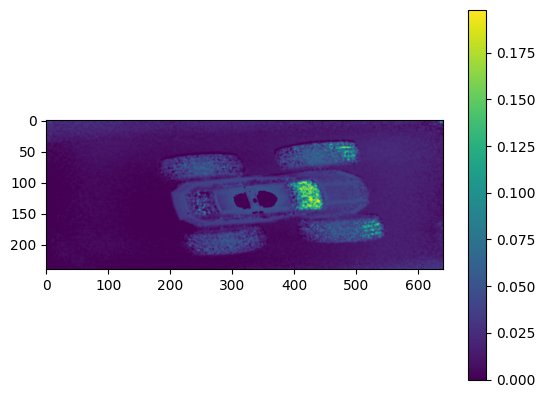

In [8]:
camera_height_above_ground = 0.2
plt.imshow(get_heights_from_distances(preprocess_image(phase_img), camera_height_above_ground))
plt.colorbar()
plt.show()

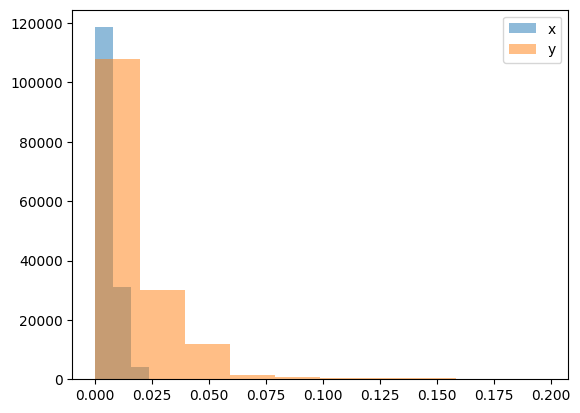

In [9]:
# plt.hist(preprocess_image(phase_img_clean).flatten(), bins=100)
# plt.show()
# plt.hist(preprocess_image(phase_img).flatten(), bins=100)
# plt.show()
plt.hist(get_heights_from_distances(preprocess_image(phase_img_clean), camera_height_above_ground).flatten(), alpha=0.5, label='x')
plt.hist(get_heights_from_distances(preprocess_image(phase_img), camera_height_above_ground).flatten(), alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

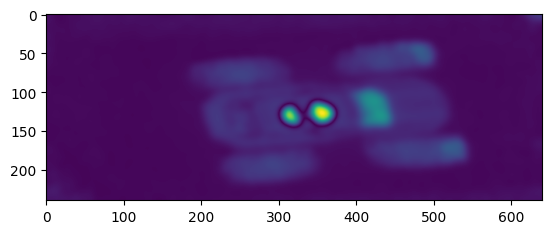

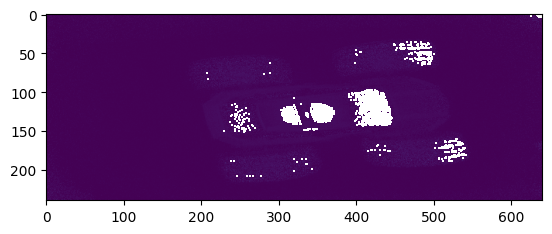

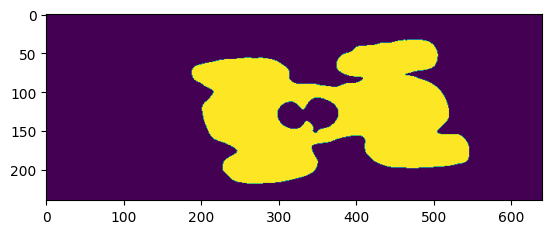

True


In [10]:
def getLargestCC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

car_cutoff = 0.02
phase_difference = np.abs(gaussian_filter(preprocess_image(phase_img_clean) - preprocess_image(phase_img), 5))
plt.imshow(phase_difference)
plt.show()
car_silhouette = phase_difference > car_cutoff
is_there_a_car = False
if np.sum(car_silhouette) > 0:
    car_silhouette = getLargestCC(car_silhouette)
    if np.sum(car_silhouette) > 1000:
        is_there_a_car = True
        
plt.imshow(np.abs(phase_img_clean - phase_img))
plt.show()
plt.imshow(car_silhouette)
plt.show()
print(is_there_a_car)

In [17]:
# Get the width and depth of the bounding box
if is_there_a_car:
    car_silhouette_where = np.where(car_silhouette == 1)
    min_width = np.min(car_silhouette_where[0])
    max_width = np.max(car_silhouette_where[0])
    min_depth = np.min(car_silhouette_where[1])
    max_depth = np.max(car_silhouette_where[1])
    print("Width: ", max_width - min_width)
    print("Depth: ", max_depth - min_depth)
    
    n_pixels = 40
    left_pixels = car_silhouette_where[:n_pixels]
    distances = phase_img[left_pixels[0], left_pixels[1]]
    displacements = math.

Width:  185
Depth:  357


In [18]:
distances

array([0.24342293, 0.24342293, 0.2389602 , ..., 0.21517299, 0.21599789,
       0.21016699], dtype=float32)